In [1]:
pip install geopandas matplotlib shapely


Note: you may need to restart the kernel to use updated packages.


Original CRS: GEOGCS["GCS_TWD97[2020]",DATUM["Taiwan_Datum_1997",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1026"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Reprojected to EPSG:4326
Number of counties in clipped region: 22


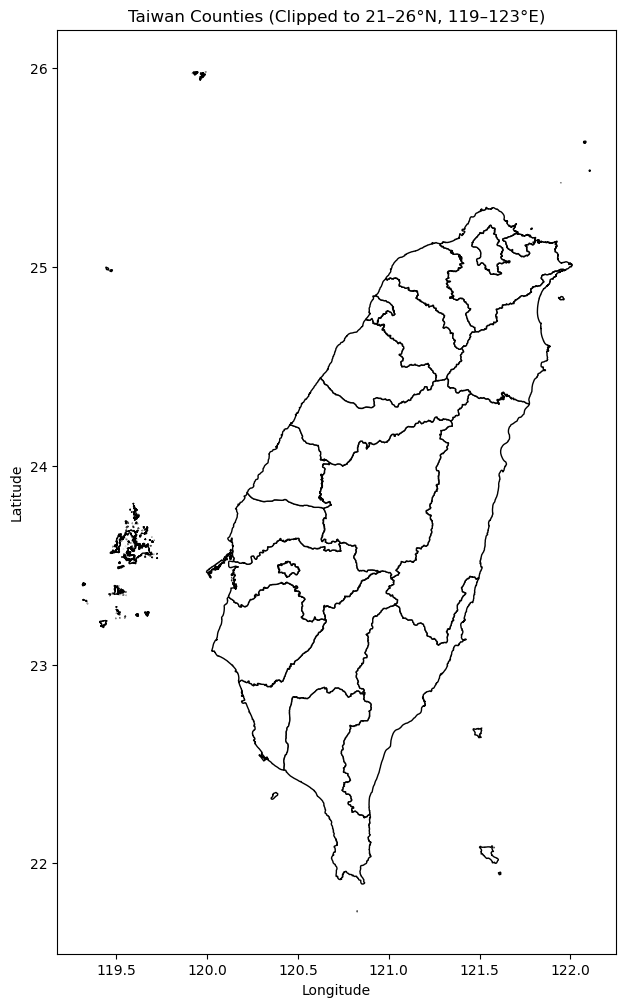

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --------------------------------------
# 1. Load county shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"  # replace with your actual path if different
gdf = gpd.read_file(file_path)

# Check CRS
print("Original CRS:", gdf.crs)

# --------------------------------------
# 2. Reproject to EPSG:4326 if needed
# --------------------------------------
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)
    print("Reprojected to EPSG:4326")

# --------------------------------------
# 3. Define bounding box geometry for clipping
# --------------------------------------
bbox = box(119, 21, 123, 26)  # (min_lon, min_lat, max_lon, max_lat)

# --------------------------------------
# 4. Clip using geopandas clip function
# --------------------------------------
gdf_clip = gpd.clip(gdf, bbox)

# Check clipped result
print("Number of counties in clipped region:", len(gdf_clip))

# --------------------------------------
# 5. Plot clipped county map
# --------------------------------------
ax = gdf_clip.plot(
    figsize=(10,12),
    edgecolor='black',
    linewidth=1,
    facecolor='white'
)

ax.set_facecolor('white')
ax.figure.set_facecolor('white')

plt.title('Taiwan Counties (Clipped to 21–26°N, 119–123°E)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Filtered rows for 2020-1: 110


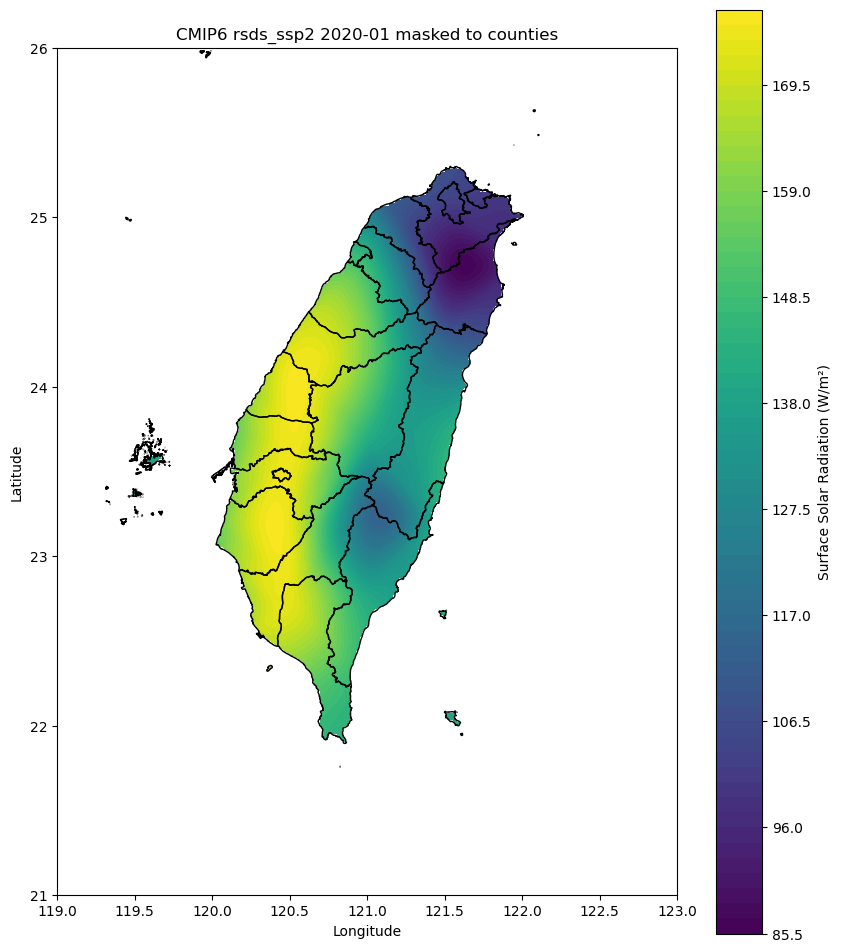

In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from scipy.interpolate import griddata

# --------------------------------------
# 0. Set target scenario, year, and month
# --------------------------------------
target_scenario = 'rsds_ssp2'  # options: 'rsds_ssp2', 'rsds_ssp3', 'rsds_ssp5'
target_year = 2020
target_month = 1

# --------------------------------------
# 1. Load county shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Clip to bounding box
bbox = box(119, 21, 123, 26)
gdf_clip = gpd.clip(gdf, bbox)

# --------------------------------------
# 2. Load CMIP6 CSV
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()

# Convert 'time' to datetime if not yet converted
df['time'] = pd.to_datetime(df['time'])

# Filter by target year and month
df_filtered = df[(df['time'].dt.year == target_year) & (df['time'].dt.month == target_month)]

print(f"Filtered rows for {target_year}-{target_month}: {len(df_filtered)}")

# --------------------------------------
# 3. Interpolate selected scenario data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_filtered[['lon','lat']].values
values = df_filtered[target_scenario].values

grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 4. Mask grid to clipped county geometries
# --------------------------------------
mask = np.ones(masked_rsds.shape, dtype=bool)

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i,j], lat2d[i,j])
        for geom in gdf_clip.geometry:
            if geom.contains(point):
                mask[i,j] = False
                break

masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 5. Plot masked contour first, then overlay county boundaries
# --------------------------------------
fig, ax = plt.subplots(figsize=(10,12))

# Plot masked contour (bottom layer)
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    cmap="viridis"
)

# Plot counties on top
gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Final plot settings
ax.set_facecolor('white')
ax.figure.set_facecolor('white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"CMIP6 {target_scenario} {target_year}-{target_month:02d} masked to counties")

# Colorbar
plt.colorbar(cf, ax=ax, orientation='vertical', label='Surface Solar Radiation (W/m²)')

plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_23620\2313815327.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_geom = gdf_clip.geometry.unary_union


Filtered rows for 2020-1: 110


C:\Users\User\AppData\Local\Temp\ipykernel_23620\2313815327.py:80: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = ~contains(unified_geom, lon_flat, lat_flat)


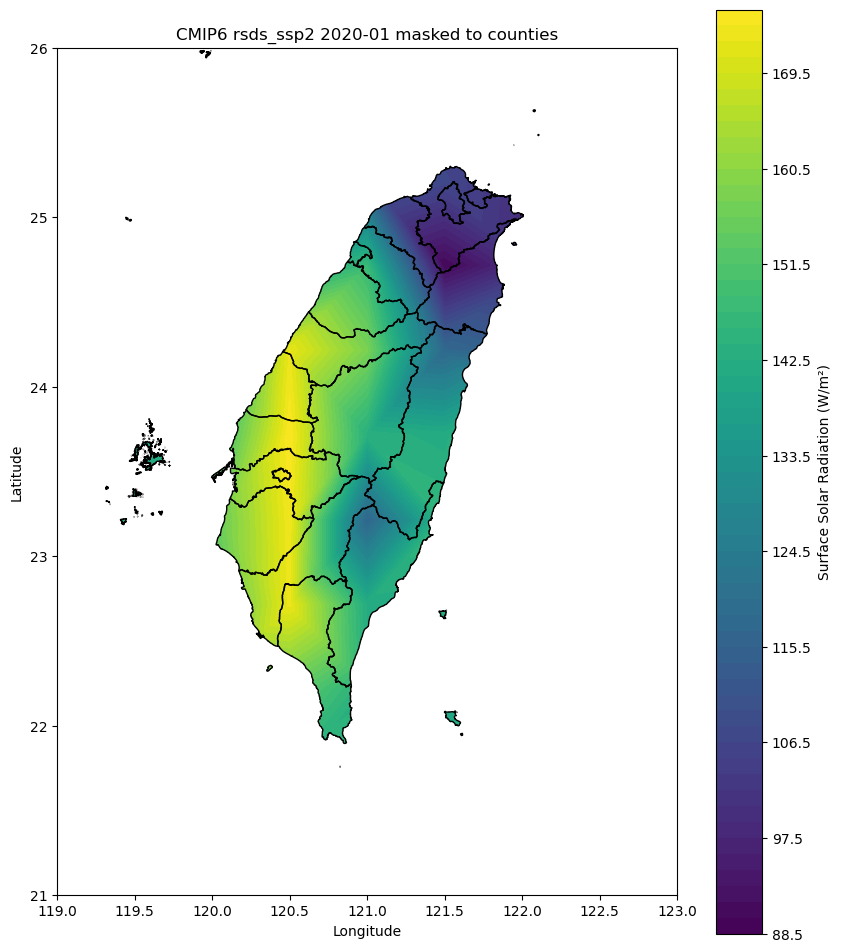

In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

# --------------------------------------
# 0. Set target scenario, year, and month
# --------------------------------------
target_scenario = 'rsds_ssp2'  # options: 'rsds_ssp2', 'rsds_ssp3', 'rsds_ssp5'
target_year = 2020
target_month = 1

# --------------------------------------
# 1. Load county shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Clip to bounding box
bbox = box(119, 21, 123, 26)
gdf_clip = gpd.clip(gdf, bbox)

# Create a single unified geometry for faster point-in-polygon testing
unified_geom = gdf_clip.geometry.unary_union

# --------------------------------------
# 2. Load CMIP6 CSV (optimized)
# --------------------------------------
# Use categorical data types for memory efficiency
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()

# Convert 'time' to datetime if not yet converted
df['time'] = pd.to_datetime(df['time'])

# Filter by target year and month early to reduce memory usage
df_filtered = df[(df['time'].dt.year == target_year) & (df['time'].dt.month == target_month)].copy()
print(f"Filtered rows for {target_year}-{target_month}: {len(df_filtered)}")

# Free up memory
del df

# --------------------------------------
# 3. Optimized interpolation
# --------------------------------------
num_points = 1500
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# Use only valid data points for interpolation
valid_mask = ~np.isnan(df_filtered[target_scenario])
points = df_filtered.loc[valid_mask, ['lon','lat']].values
values = df_filtered.loc[valid_mask, target_scenario].values

# Use linear interpolation (faster than cubic) or keep cubic if quality is critical
grid_rsds = griddata(points, values, (lon2d, lat2d), method='linear')
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 4. Vectorized masking using unified geometry
# --------------------------------------
# Create flat arrays of grid coordinates
lon_flat = lon2d.ravel()
lat_flat = lat2d.ravel()

# Create points array
grid_points = np.column_stack([lon_flat, lat_flat])

# Vectorized point-in-polygon test using the unified geometry
from shapely.vectorized import contains
mask_flat = ~contains(unified_geom, lon_flat, lat_flat)

# Reshape mask back to grid shape
mask = mask_flat.reshape(lon2d.shape)

# Apply mask
masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 5. Optimized plotting
# --------------------------------------
fig, ax = plt.subplots(figsize=(10,12))

# Plot masked contour (bottom layer)
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    cmap="viridis"
)

# Plot counties on top
gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Final plot settings
ax.set_facecolor('white')
ax.figure.set_facecolor('white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"CMIP6 {target_scenario} {target_year}-{target_month:02d} masked to counties")

# Colorbar
plt.colorbar(cf, ax=ax, orientation='vertical', label='Surface Solar Radiation (W/m²)')

plt.show()

# Optional: Alternative ultra-fast approach using rasterio if you have it installed


Filtered rows for 2020-1: 110


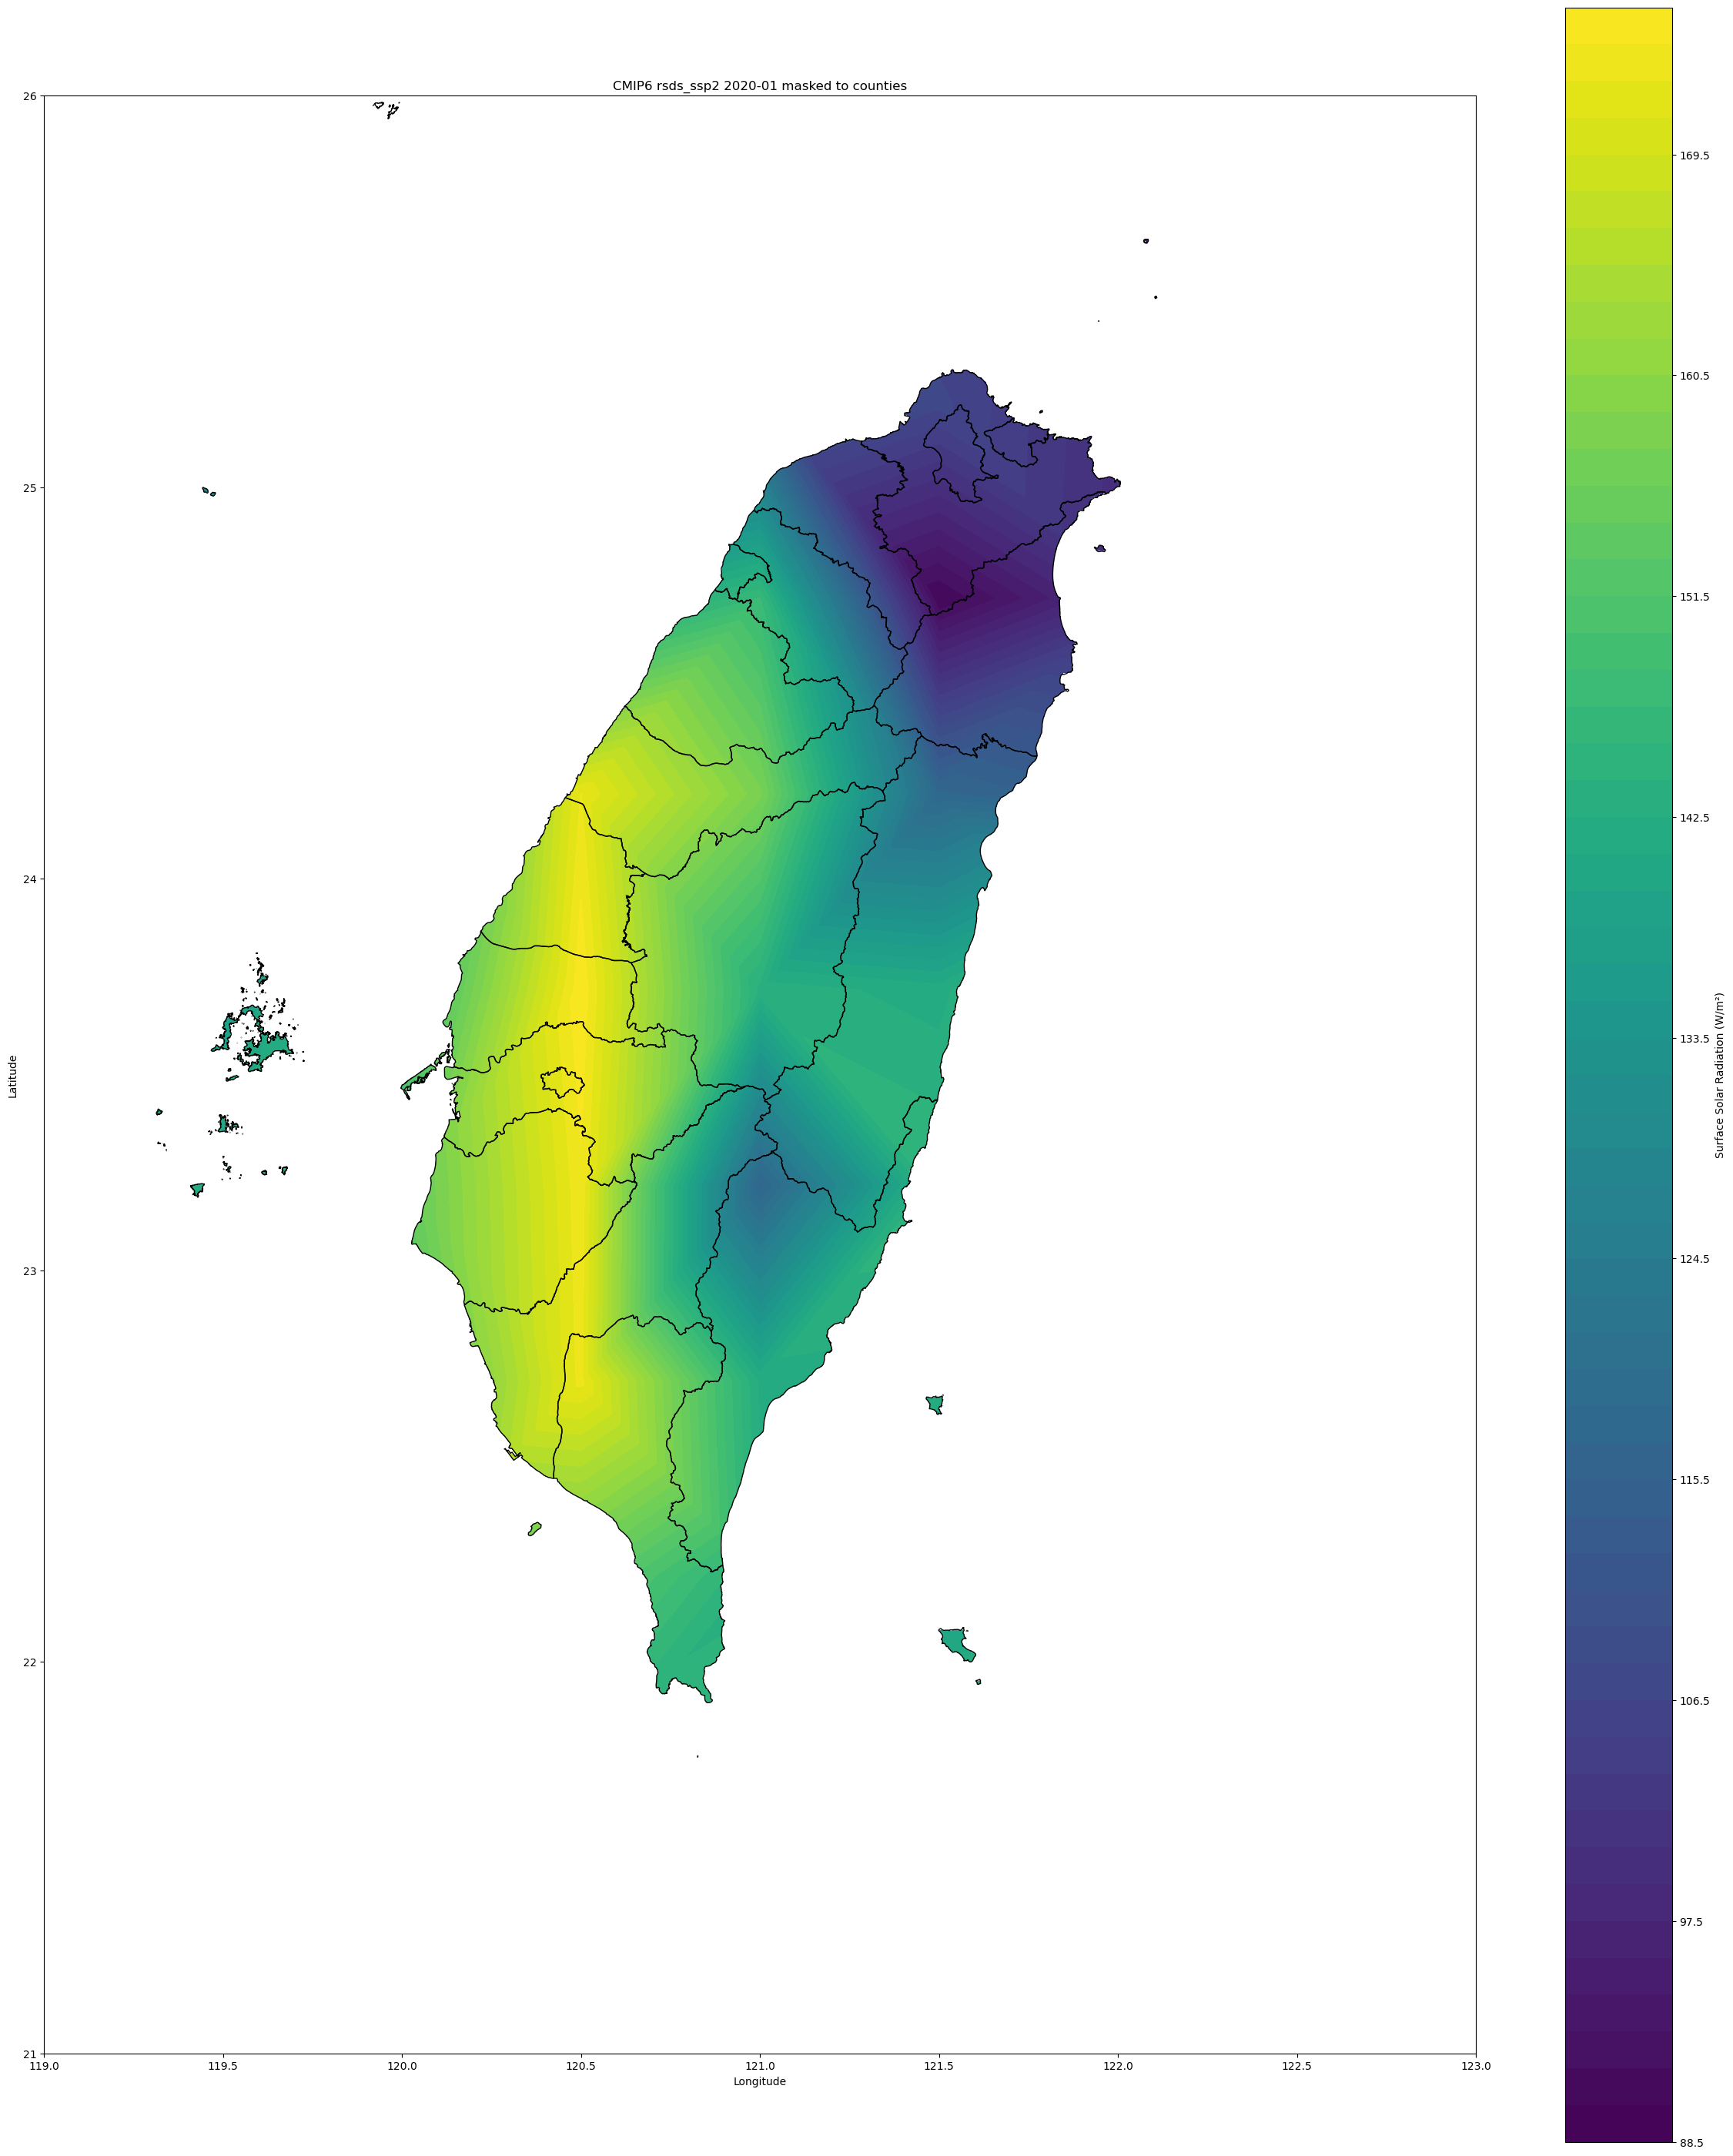

In [15]:
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

# --------------------------------------
# 0. Set target scenario, year, and month
# --------------------------------------
target_scenario = 'rsds_ssp2'  # options: 'rsds_ssp2', 'rsds_ssp3', 'rsds_ssp5'
target_year = 2020
target_month = 1

# --------------------------------------
# 1. Load county shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Clip to bounding box
bbox = box(119, 21, 123, 26)
gdf_clip = gpd.clip(gdf, bbox)

# No need for unified geometry with rasterio approach

# --------------------------------------
# 2. Load CMIP6 CSV (optimized)
# --------------------------------------
# Use categorical data types for memory efficiency
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()

# Convert 'time' to datetime if not yet converted
df['time'] = pd.to_datetime(df['time'])

# Filter by target year and month early to reduce memory usage
df_filtered = df[(df['time'].dt.year == target_year) & (df['time'].dt.month == target_month)].copy()
print(f"Filtered rows for {target_year}-{target_month}: {len(df_filtered)}")

# Free up memory
del df

# --------------------------------------
# 3. Optimized interpolation
# --------------------------------------
num_points = 1500
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# Use only valid data points for interpolation
valid_mask = ~np.isnan(df_filtered[target_scenario])
points = df_filtered.loc[valid_mask, ['lon','lat']].values
values = df_filtered.loc[valid_mask, target_scenario].values

# Use linear interpolation (faster than cubic) or keep cubic if quality is critical
grid_rsds = griddata(points, values, (lon2d, lat2d), method='linear')
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 4. Ultra-fast rasterization masking
# --------------------------------------
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Create a transform for the grid (note: rasterio uses (width, height) order)
transform = from_bounds(119, 21, 123, 26, num_points, num_points)

# Rasterize the geometries - this is much faster than point-in-polygon testing
shapes = [(geom, 1) for geom in gdf_clip.geometry]
raster_mask = rasterize(shapes, out_shape=(num_points, num_points), transform=transform)

# Apply mask (invert because rasterize gives 1 for inside, 0 for outside)
# Also flip vertically to match the coordinate system
mask = np.flipud(raster_mask) == 0
masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 5. Optimized plotting
# --------------------------------------
fig, ax = plt.subplots(figsize=(30,36))

# Plot masked contour (bottom layer)
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    cmap="viridis"
)

# Plot counties on top
gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Final plot settings
ax.set_facecolor('white')
ax.figure.set_facecolor('white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"CMIP6 {target_scenario} {target_year}-{target_month:02d} masked to counties")

# Colorbar
plt.colorbar(cf, ax=ax, orientation='vertical', label='Surface Solar Radiation (W/m²)')

plt.show()

# Installation note: pip install rasterio
# This approach is typically 10-20x faster than vectorized shapely operations

Filtered rows for 2020-1: 110


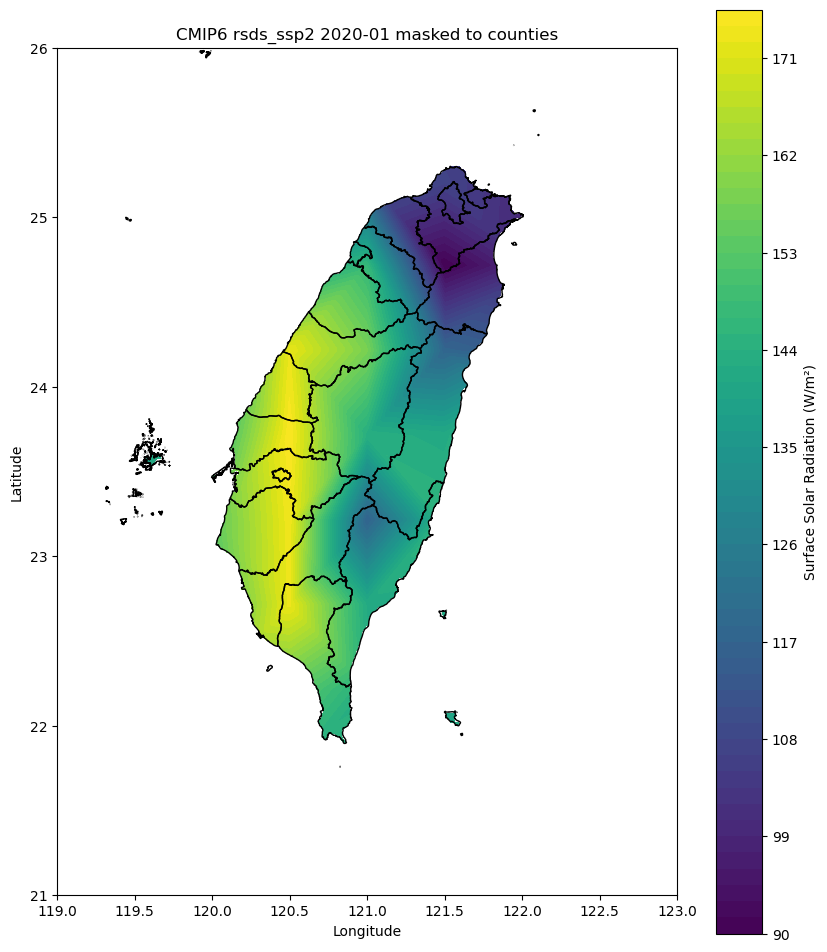


=== PV Output Analysis for 新竹縣 ===
Analysis Period: 2020-01
Solar Scenario: rsds_ssp2

County: 新竹縣
Total Grid Cells: 572
Average Solar Irradiance: 129.17 W/m²
Max Solar Irradiance: 148.56 W/m²
Min Solar Irradiance: 107.93 W/m²

PV System Parameters:
  - Panel Efficiency: 20.0%
  - System Losses: 14.0%
  - Grid Cell Area: 2510910.48 m²

Total PV Power Output:
  - 31910273379 W
  - 31910273.38 kW
  - 31910.2734 MW

Note: This is instantaneous power based on irradiance data.
For daily/monthly energy, multiply by appropriate time factors.


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

# --------------------------------------
# 0. Set target scenario, year, and month
# --------------------------------------
target_scenario = 'rsds_ssp2'  # options: 'rsds_ssp2', 'rsds_ssp3', 'rsds_ssp5'
target_year = 2020
target_month = 1

# --------------------------------------
# 1. Load county shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Clip to bounding box
bbox = box(119, 21, 123, 26)
gdf_clip = gpd.clip(gdf, bbox)

# No need for unified geometry with rasterio approach

# --------------------------------------
# 2. Load CMIP6 CSV (optimized)
# --------------------------------------
# Use categorical data types for memory efficiency
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()

# Convert 'time' to datetime if not yet converted
df['time'] = pd.to_datetime(df['time'])

# Filter by target year and month early to reduce memory usage
df_filtered = df[(df['time'].dt.year == target_year) & (df['time'].dt.month == target_month)].copy()
print(f"Filtered rows for {target_year}-{target_month}: {len(df_filtered)}")

# Free up memory
del df

# --------------------------------------
# 3. Optimized interpolation
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# Use only valid data points for interpolation
valid_mask = ~np.isnan(df_filtered[target_scenario])
points = df_filtered.loc[valid_mask, ['lon','lat']].values
values = df_filtered.loc[valid_mask, target_scenario].values

# Use linear interpolation (faster than cubic) or keep cubic if quality is critical
grid_rsds = griddata(points, values, (lon2d, lat2d), method='linear')
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 4. Ultra-fast rasterization masking
# --------------------------------------
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Create a transform for the grid (note: rasterio uses (width, height) order)
transform = from_bounds(119, 21, 123, 26, num_points, num_points)

# Rasterize the geometries - this is much faster than point-in-polygon testing
shapes = [(geom, 1) for geom in gdf_clip.geometry]
raster_mask = rasterize(shapes, out_shape=(num_points, num_points), transform=transform)

# Apply mask (invert because rasterize gives 1 for inside, 0 for outside)
# Also flip vertically to match the coordinate system
mask = np.flipud(raster_mask) == 0
masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 5. Optimized plotting
# --------------------------------------
fig, ax = plt.subplots(figsize=(10,12))

# Plot masked contour (bottom layer)
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    cmap="viridis"
)

# Plot counties on top
gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Final plot settings
ax.set_facecolor('white')
ax.figure.set_facecolor('white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"CMIP6 {target_scenario} {target_year}-{target_month:02d} masked to counties")

# Colorbar
plt.colorbar(cf, ax=ax, orientation='vertical', label='Surface Solar Radiation (W/m²)')

plt.show()

# Installation note: pip install rasterio
# This approach is typically 10-20x faster than vectorized shapely operations

# --------------------------------------
# 6. Function to calculate total PV output for a specific county
# --------------------------------------
def calculate_county_pvout(county_name, gdf_counties, lon2d, lat2d, solar_data, 
                          pv_efficiency=0.20, system_losses=0.14, panel_area_per_cell=1.0):

    # Filter for target county
    county_gdf = gdf_counties[gdf_counties['COUNTYNAME'] == county_name].copy()
    
    if len(county_gdf) == 0:
        print(f"County '{county_name}' not found!")
        available_counties = gdf_counties['COUNTYNAME'].unique()
        print(f"Available counties: {sorted(available_counties)}")
        return None
    
    # Create raster mask for the specific county
    transform = from_bounds(lon2d.min(), lat2d.min(), lon2d.max(), lat2d.max(), 
                           lon2d.shape[1], lon2d.shape[0])
    
    shapes = [(geom, 1) for geom in county_gdf.geometry]
    county_mask = rasterize(shapes, out_shape=lon2d.shape, transform=transform)
    county_mask = np.flipud(county_mask) == 1  # True for inside county
    
    # Extract solar data for the county
    county_solar = solar_data[county_mask]
    county_solar_valid = county_solar[~np.isnan(county_solar)]
    
    if len(county_solar_valid) == 0:
        print(f"No valid solar data found for {county_name}")
        return None
    
    # Calculate PV output (simplified model)
    # PV Power = Solar Irradiance × Panel Area × Efficiency × (1 - System Losses)
    pv_power_per_cell = county_solar_valid * panel_area_per_cell * pv_efficiency * (1 - system_losses)
    
    # Grid cell area (approximate, assuming uniform grid)
    lat_spacing = (lat2d.max() - lat2d.min()) / lat2d.shape[0]
    lon_spacing = (lon2d.max() - lon2d.min()) / lon2d.shape[1]
    
    # Convert to actual area (rough approximation in m²)
    # 1 degree ≈ 111 km, but this varies with latitude
    avg_lat = np.mean(lat2d)
    lat_to_m = 111000  # meters per degree latitude
    lon_to_m = 111000 * np.cos(np.radians(avg_lat))  # meters per degree longitude
    
    cell_area_m2 = lat_spacing * lon_spacing * lat_to_m * lon_to_m
    
    # Total PV output for the county
    total_pv_power = np.sum(pv_power_per_cell) * cell_area_m2 / panel_area_per_cell
    
    # Calculate statistics
    stats = {
        'county_name': county_name,
        'total_cells': len(county_solar_valid),
        'avg_solar_irradiance': np.mean(county_solar_valid),
        'max_solar_irradiance': np.max(county_solar_valid),
        'min_solar_irradiance': np.min(county_solar_valid),
        'total_pv_power_watts': total_pv_power,
        'total_pv_power_kw': total_pv_power / 1000,
        'total_pv_power_mw': total_pv_power / 1000000,
        'cell_area_m2': cell_area_m2,
        'pv_efficiency': pv_efficiency,
        'system_losses': system_losses
    }
    
    return stats

# --------------------------------------
# 7. Calculate PV output for target county
# --------------------------------------
target_county = "新竹縣"

# Calculate PV output for the target county
pv_stats = calculate_county_pvout(
    county_name=target_county,
    gdf_counties=gdf_clip,
    lon2d=lon2d,
    lat2d=lat2d,
    solar_data=masked_rsds.data,  # Use the unmasked data, function will handle masking
    pv_efficiency=0.20,  # 20% efficiency
    system_losses=0.14,  # 14% system losses
    panel_area_per_cell=1.0  # 1 m² panel area per grid cell
)

# Display results
if pv_stats:
    print(f"\n=== PV Output Analysis for {target_county} ===")
    print(f"Analysis Period: {target_year}-{target_month:02d}")
    print(f"Solar Scenario: {target_scenario}")
    print(f"")
    print(f"County: {pv_stats['county_name']}")
    print(f"Total Grid Cells: {pv_stats['total_cells']}")
    print(f"Average Solar Irradiance: {pv_stats['avg_solar_irradiance']:.2f} W/m²")
    print(f"Max Solar Irradiance: {pv_stats['max_solar_irradiance']:.2f} W/m²")
    print(f"Min Solar Irradiance: {pv_stats['min_solar_irradiance']:.2f} W/m²")
    print(f"")
    print(f"PV System Parameters:")
    print(f"  - Panel Efficiency: {pv_stats['pv_efficiency']*100:.1f}%")
    print(f"  - System Losses: {pv_stats['system_losses']*100:.1f}%")
    print(f"  - Grid Cell Area: {pv_stats['cell_area_m2']:.2f} m²")
    print(f"")
    print(f"Total PV Power Output:")
    print(f"  - {pv_stats['total_pv_power_watts']:.0f} W")
    print(f"  - {pv_stats['total_pv_power_kw']:.2f} kW")
    print(f"  - {pv_stats['total_pv_power_mw']:.4f} MW")
    print(f"")
    print(f"Note: This is instantaneous power based on irradiance data.")
    print(f"For daily/monthly energy, multiply by appropriate time factors.")
    
